<a href="https://colab.research.google.com/github/owrmille/exploring_weather_trends/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
игрок может совершать одно из двух действий:
hit  — взять ещё одну карту;
stand — не брать больше карт;
если сумма очков у игрока на руках больше 21, он проигрывает (bust);
если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

### Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [ ]:
!pip install gym tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 30.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 30.0 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 27.4 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict

import gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [ ]:
def simple_strategy(state):
    return state[0] < 19


def play_round(env):
    state, _ = env.reset()
    finished = False    
    while not finished:
        action = simple_strategy(state)
        state, reward, finished, _, _ = env.step(action)
    return reward


def monte_carlo_estimation(n: int):
    env = gym.make('Blackjack-v1', natural=False)
    total_reward = 0
    for _ in tqdm(range(n), total=n):
        total_reward += play_round(env)
    estimation = total_reward / n
    return estimation

In [ ]:
N = 10 ** 6
f'Monte Carlo Estimation: {monte_carlo_estimation(N)}'

  6%|▌         | 62437/1000000 [00:04<01:00, 15374.00it/s]


KeyboardInterrupt: 

### Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [ ]:
def compute_policy_by_Q(Q):
    pi = defaultdict(lambda: np.random.randint(env.action_space.n))
    for state, actions in Q.items():
        pi[state] = np.argmax(actions)
    return pi

def get_action(env, pi, state, eps):
    return pi[state] if np.random.rand() > eps else np.random.randint(env.action_space.n)

def run_episode(env, pi, eps):
    state, _ = env.reset()
    action = get_action(env, pi, state, eps)
    states, rewards, actions = [state], [0], [action]
    finished = False    
    while not finished:
        state, reward, finished, _, _ = env.step(action)
        states.append(state)
        rewards.append(reward)
        action = get_action(env, pi, state, eps)
        actions.append(action)
    return states, actions, rewards

def update_returns_actions(R, Q, states, actions, rewards, gamma):
    g = 0
    for t in range(len(states) - 2, -1, -1):
        g =  g * gamma + rewards[t + 1]
        R[states[t], actions[t]].append(g)
        Q[states[t]][actions[t]] = np.mean(R[states[t], actions[t]])

def monte_carlo_control(env, n: int, eps: float = 0.0, gamma: float = 1.0, block_size: int = 100_000):
    Q = defaultdict(lambda: np.random.rand(env.action_space.n))  # key: (player's sum, dealer's card, ace)
    R = defaultdict(list)  # key: ((player's sum, dealer's card, ace), action)
    mean_rewards = []
    cur_rewards = [-1] * block_size
    pi = compute_policy_by_Q(Q)
    for i in tqdm(range(n + 1), total=n):
        if i and i % block_size == 0:
            mean_rewards.append(np.mean(cur_rewards))
            cur_rewards = [-1] * block_size
        states, actions, rewards = run_episode(env, pi, eps)
        update_returns_actions(R, Q, states, actions, rewards, gamma=gamma)
        pi = compute_policy_by_Q(Q)
        cur_rewards[i % block_size] = rewards[-1]
    return mean_rewards, pi

In [ ]:
EPS = 0.1
GAMMA = 0.9
N = 10 ** 6

env = gym.make('Blackjack-v1', natural=False, render_mode="rgb_array")
mean_rewards, pi = monte_carlo_control(env, N, EPS, GAMMA)

100%|██████████| 1000000/1000000 [30:17<00:00, 550.36it/s]


### Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

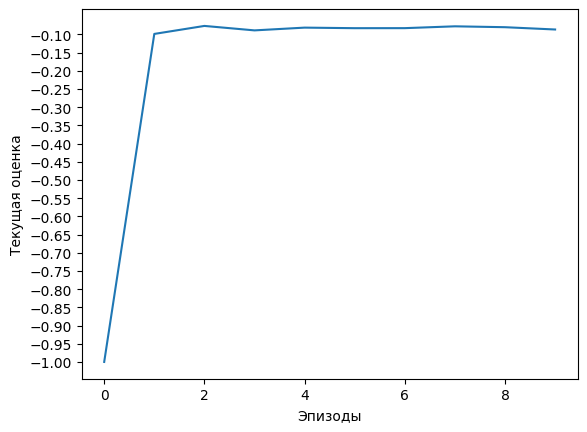

In [ ]:
def plot_rewards(mean_rewards):
    plt.plot(np.arange(len(mean_rewards)), mean_rewards)
    plt.yticks(np.arange(np.min(mean_rewards), np.max(mean_rewards), 0.05)),
    plt.xlabel("Эпизоды")
    plt.ylabel("Текущая оценка")
plot_rewards(mean_rewards)

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

In [ ]:
from typing import Optional
from gym import spaces
from gym.envs.toy_text.blackjack import (
    BlackjackEnv, cmp, draw_card, is_bust, score, sum_hand
)


class BlackjackWithDoubleEnv(BlackjackEnv):
    def __init__(self, render_mode: Optional[str] = None):
        super().__init__(render_mode, False, False)
        self.action_space = spaces.Discrete(3)

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
        if action == 1:
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if action == 2:
                reward *= 2
        return self._get_obs(), reward, terminated, False, {}



In [ ]:
double_env = BlackjackWithDoubleEnv()
double_mean_rewards, double_pi = monte_carlo_control(double_env, N, EPS, GAMMA)

100%|██████████| 1000000/1000000 [29:10<00:00, 571.33it/s]


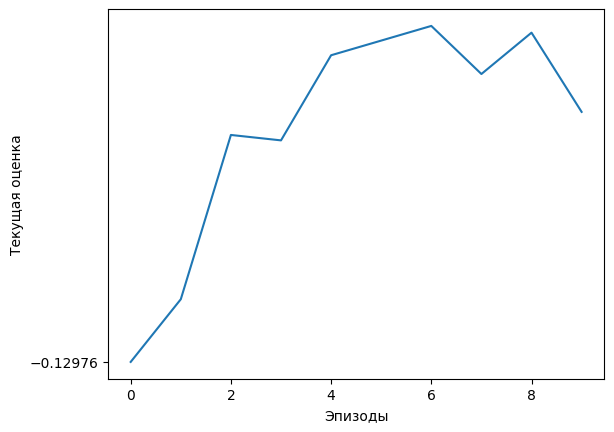

In [ ]:
plot_rewards(double_mean_rewards)